# Salary Prediction: Version 1.0

## Setup

In [1]:
# libraries to deal with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# libraries to save/load models
import os
import joblib

## Loading Dataset

In [2]:
df = pd.read_csv("../data/Extended_Employee_Performance_and_Productivity_Data.csv", delimiter=",")
df.head()

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2022-01-19 08:03:05.556036,2,High School,5,6750.0,33,32,22,2,0,14,66,0,2.63,False
1,2,Finance,Male,29,Developer,2024-04-18 08:03:05.556036,0,High School,5,7500.0,34,34,13,14,100,12,61,2,1.72,False
2,3,Finance,Male,55,Specialist,2015-10-26 08:03:05.556036,8,High School,3,5850.0,37,27,6,3,50,10,1,0,3.17,False
3,4,Customer Support,Female,48,Analyst,2016-10-22 08:03:05.556036,7,Bachelor,2,4800.0,52,10,28,12,100,10,0,1,1.86,False
4,5,Engineering,Female,36,Analyst,2021-07-23 08:03:05.556036,3,Bachelor,2,4800.0,38,11,29,13,100,15,9,1,1.25,False


## Exploratory Data Analysis: Feature Selection

In [3]:
# get all column names
all_cols = df.columns
all_cols

Index(['Employee_ID', 'Department', 'Gender', 'Age', 'Job_Title', 'Hire_Date',
       'Years_At_Company', 'Education_Level', 'Performance_Score',
       'Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled',
       'Overtime_Hours', 'Sick_Days', 'Remote_Work_Frequency', 'Team_Size',
       'Training_Hours', 'Promotions', 'Employee_Satisfaction_Score',
       'Resigned'],
      dtype='object')

In [4]:
# get column names with object datatype
object_cols = [col for col in all_cols if df[col].dtype == "object"]

# check cardinality (number of unique values in each column)
cardinality = list(map(lambda col: df[col].nunique(), object_cols))
d = dict(zip(object_cols, cardinality))
sorted(d.items(), key=lambda x: x[1])

[('Gender', 3),
 ('Education_Level', 4),
 ('Job_Title', 7),
 ('Department', 9),
 ('Hire_Date', 3650)]

The following columns are excluded from the model:

- **Employee_ID**: Unique identifier with no predictive value
- **Gender**: Removed due to ethical concerns and potential representation bias
- **Age**: Removed due to ethical concerns and potential age discrimination in salary recommendations
- **Department**: Redundant with `Job_Title`, which is more standardized across companies
- **Hire_Date**: Specific hire dates are not relevant for salary-based performance prediction; high cardinality makes encoding impractical
- **Years_At_Company**: Excluded to ensure the model applies to new hires and salary negotiations, where tenure may be zero or irrelevant
- **Promotions**: Removed because promotions are an outcome of past performance; promotions are unavailable for new hires
- **Employee_Satisfaction_Score**: Removed because satisfaction is an outcome of past performance; scores are unavailable for new hires
- **Resigned**: Outcome variable that would introduce data leakage

In [5]:
cols_to_drop = ["Employee_ID", "Gender", "Age", "Department", "Hire_Date", "Years_At_Company", "Promotions", "Employee_Satisfaction_Score", "Resigned"]
df = df.drop(columns=cols_to_drop)
df.head()

,Job_Title,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours
0,Specialist,High School,5,6750.0,33,32,22,2,0,14,66
1,Developer,High School,5,7500.0,34,34,13,14,100,12,61
2,Specialist,High School,3,5850.0,37,27,6,3,50,10,1
3,Analyst,Bachelor,2,4800.0,52,10,28,12,100,10,0
4,Analyst,Bachelor,2,4800.0,38,11,29,13,100,15,9


In [6]:
# check distribution
score_counts = df["Performance_Score"].value_counts()
score_counts

Performance_Score
1    20120
2    20013
3    19999
4    19940
5    19928
Name: count, dtype: int64

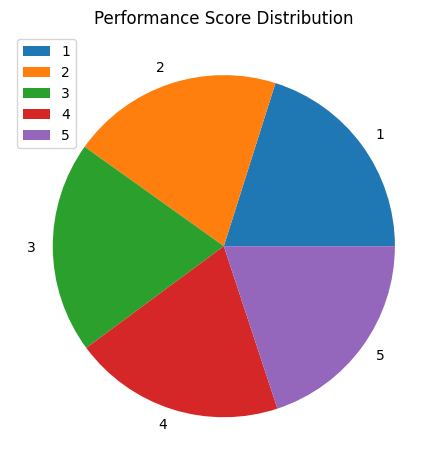

In [7]:
# visualize distribution
score_counts.plot(kind='pie', legend=True)
plt.title('Performance Score Distribution')
plt.ylabel('')  # to remove default label

plt.tight_layout()
plt.show()

## Exploratory Data Analysis: Checking Monthly Salary w.r.t Job Title

In [8]:
# check distribution
avg_salary_for_jobs = df.groupby("Job_Title")["Monthly_Salary"].mean()
avg_salary_for_jobs

Job_Title
Analyst       5195.820770
Consultant    7152.090077
Developer     6490.137372
Engineer      7799.324752
Manager       7798.324607
Specialist    5855.335355
Technician    4545.148757
Name: Monthly_Salary, dtype: float64

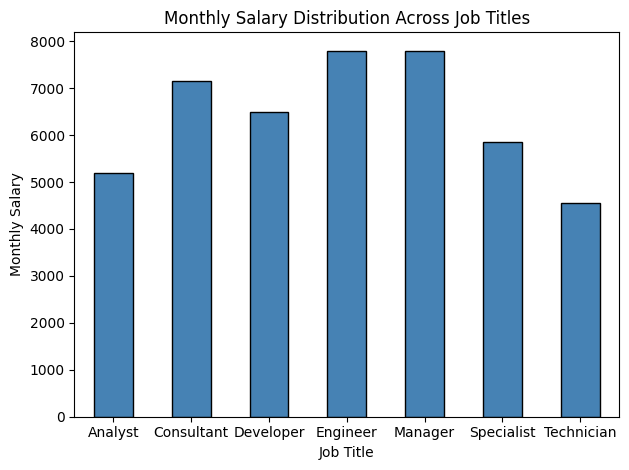

In [9]:
# visualize distribution
avg_salary_for_jobs.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Job Title')
plt.ylabel('Monthly Salary')
plt.title('Monthly Salary Distribution Across Job Titles')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Average pay varies across roles, with some offering higher compensation.

## Exploratory Data Analysis: Checking Monthly Salary w.r.t Education Level

In [10]:
# check distribution
avg_salary_for_edu = df.groupby("Education_Level")["Monthly_Salary"].mean()
avg_salary_for_edu

Education_Level
Bachelor       6398.421295
High School    6399.356752
Master         6417.448336
PhD            6431.548208
Name: Monthly_Salary, dtype: float64

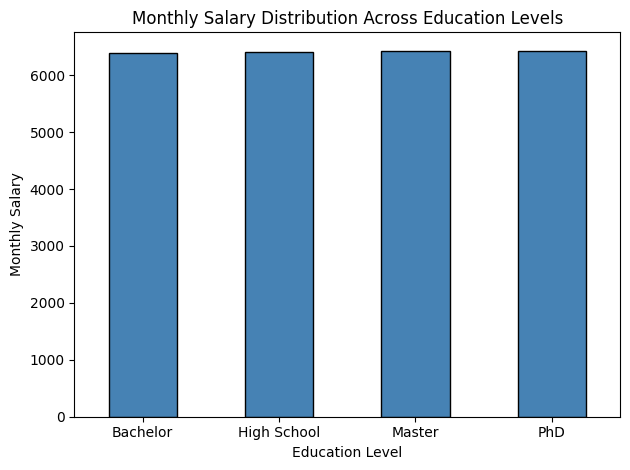

In [11]:
# visualize distribution
avg_salary_for_edu.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Education Level')
plt.ylabel('Monthly Salary')
plt.title('Monthly Salary Distribution Across Education Levels')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Exploratory Data Analysis: Checking Feature-Target Relationship

In [12]:
# get all columns
cols_info = joblib.load('../data/processed/performance_feature_info.pkl')

for key, value in cols_info.items():
    locals()[key] = value

In [13]:
# get numeric column names
numeric_cols

['Performance_Score',
 'Monthly_Salary',
 'Work_Hours_Per_Week',
 'Projects_Handled',
 'Overtime_Hours',
 'Sick_Days',
 'Remote_Work_Frequency',
 'Team_Size',
 'Training_Hours']

In [14]:
# get categorical column names
categorical_cols

['Job_Title', 'Education_Level']

In [15]:
# check correlations for numeric columns
df[numeric_cols].corr()['Monthly_Salary'].sort_values(ascending=False)

Monthly_Salary           1.000000
Performance_Score        0.510035
Sick_Days                0.003610
Team_Size                0.002972
Remote_Work_Frequency   -0.000464
Training_Hours          -0.001088
Projects_Handled        -0.001925
Work_Hours_Per_Week     -0.002347
Overtime_Hours          -0.003029
Name: Monthly_Salary, dtype: float64

In [16]:
# check ANOVA for group comparisons for categorical columns
for col in categorical_cols:  # for each column
    groups = []
    for val in df[col].unique():  # for each unique value in each column
        groups.append(df[df[col]==val]['Monthly_Salary'])

    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\n{col}:")
    print(f"  ANOVA p-value: {p_value:.6f}")
    if p_value < 0.05:
        print(f"  - Statistically significant at 95% confidence")
        print()
        print(df.groupby(col)['Monthly_Salary'].mean())  # show group means
    else:
        print(f"  - Not statistically significant at 95% confidence")


Job_Title:
  ANOVA p-value: 0.000000
  - Statistically significant at 95% confidence

Job_Title
Analyst       5195.820770
Consultant    7152.090077
Developer     6490.137372
Engineer      7799.324752
Manager       7798.324607
Specialist    5855.335355
Technician    4545.148757
Name: Monthly_Salary, dtype: float64

Education_Level:
  ANOVA p-value: 0.203300
  - Not statistically significant at 95% confidence


## Data Preprocessing: Data Splitting

To prevent data leakage, the dataset must be split into training and test sets before fitting any encoders or scalers. This ensures that information from the test set does not influence the training process.

In [17]:
# separate features and target
target_col = ["Monthly_Salary"]
if sorted(list(set(numeric_cols + categorical_cols) - set(target_col))) == sorted(list(set(df.columns) - set(target_col))):
    features_col = list(set(df.columns) - set(target_col))
    X = df[features_col]
    y = df[target_col]
else:
    print("There is a mismatch in columns")

In [18]:
# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Preprocessing: Encoding Categorical Variables as Numeric

There are two categorical columns to be transformed into numeric columns through ordinal encoding or one-hot encoding.

In [19]:
print(X_train['Education_Level'].unique())

['Bachelor' 'Master' 'High School' 'PhD']


The `Education_Level` column shows a clear ordinal relationship, as the categories represent increasing education level (High School → Bachelor → Master → PhD). Therefore, it is encoded using ordinal encoding. 

In [20]:
# define the correct order
education_order = [['High School', 'Bachelor', 'Master', 'PhD']]

# get ordinal column names
ordinal_cols

['Education_Level']

In [21]:
print((X_train['Job_Title'].unique()))

['Technician' 'Developer' 'Manager' 'Consultant' 'Specialist' 'Analyst'
 'Engineer']


The `Job_Title` column contains multiple categorical values with no natural order. Encoding them as ordinal values would introduce artificial relationships between categories, so they are encoded using one-hot (dummy) encoding.

In [22]:
# get one-hot column names
onehot_cols

['Job_Title']

## Data Preprocessing: Creating a Column Transformer

This is an object made to accept the dataset and transform it on the fly to produce the encoded and scaled features ready for machine learning models. It includes the standard scaler for numeric columns, the ordinal encoder for ordinal columns, and the one-hot encoder for one-hot columns.

The benefit of using this instead of manual scaling or encoding process for each column type is that it handles all transformations in a single, consistent operation, ensures proper train/test separation (fits only on training data), integrates seamlessly with sklearn pipelines for easy model training and grid search, and reduces code complexity while minimizing errors.

The `remainder` parameter is used to specify how to handle columns that are not explicitly listed in the transformers. It is set to `'passthrough'` to keep any unlisted columns in their original form without transformation. Alternatively, it can be set to `'drop'` to exclude unlisted columns from the output.

In [23]:
# to verify
len(features_col)

10

In [24]:
# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list(set(numeric_cols) - set(target_col))),  # all numeric columns except the target
        ('ordinal', OrdinalEncoder(categories=education_order), ordinal_cols),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), onehot_cols),
    ],
    remainder='passthrough'
)

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('ordinal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``featur

## Model: Selection Rationale

Five models are selected for performance prediction:

1. **Logistic Regression**: A baseline model offering interpretability through coefficient analysis, useful for understanding relationships between salary, features, and performance categories.

2. **Ridge Classifier**: A regularized linear classification model that handles multicollinearity and prevents overfitting through L2 regularization, providing a more robust baseline than standard logistic regression.

3. **Random Forest Classifier**: An ensemble method that reduces overfitting through multiple trees. It handles feature interactions well and provides feature importance, making it suitable for identifying key performance drivers.

4. **Gradient Boosting Classifier**: A boosting algorithm that sequentially builds models to correct previous errors, effective at capturing complex non-linear relationships between salary, work factors, and performance categories.

5. **XGBoost Classifier**: An optimized gradient boosting algorithm with built-in regularization and efficient implementation. It typically delivers high predictive performance and is well-suited for tabular data with mixed feature types, especially effective for multiclass classification tasks.

These models represent different approaches (linear, bagging, and boosting), enabling comprehensive comparison for robust performance prediction.

In [25]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

## Model: Cross-Validation
Cross-validation provides a robust performance estimate by splitting training data into multiple folds, using each fold for both training and validation. This gives a more reliable estimate than a single train-test split.

Cross-validation should be performed **before fitting the model**.

The `neg_mean_squared_error` metric is used because:
- Squared: penalizes larger errors more than smaller ones
- Mean: averages across all data points
- Neg: adapts MSE to sklearn's "higher is better" convention

In [26]:
cv_results = {}

# perform regular 5-fold cross validation for each model
for name, model in models.items():
    # create pipeline for each model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    cv_results[name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"\n{name}:")
    print(f"  negative average squared error (5-fold cv): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Linear Regression:
  negative average squared error (5-fold cv): -16296.0557 (+/- 326.1676)

Ridge Regression:
  negative average squared error (5-fold cv): -16296.2185 (+/- 327.8322)

Random Forest:
  negative average squared error (5-fold cv): 0.0000 (+/- 0.0000)

Gradient Boosting:
  negative average squared error (5-fold cv): -12322.9145 (+/- 800.5000)

XGBoost:
  negative average squared error (5-fold cv): -0.0038 (+/- 0.0032)


It appears that 2 out of 5 models achieve near-perfect predictions. This suggests possible overfitting, which may be caused by data leakage or issues with the dataset itself (for example, a synthetic dataset with highly predictable patterns).

## Model: Identifying Overfitting

In [27]:
features_col

['Team_Size',
 'Work_Hours_Per_Week',
 'Projects_Handled',
 'Sick_Days',
 'Overtime_Hours',
 'Job_Title',
 'Remote_Work_Frequency',
 'Education_Level',
 'Performance_Score',
 'Training_Hours']

These features look reasonable for predicting monthly salary.

In [28]:
# check if the dataset (all feature combinations) is deterministic
unique_mapping = df.groupby(features_col)['Monthly_Salary'].nunique()
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

total unique combinations: 100000
number of times the same feature combination has different Monthly_Salary: 0
percentage where same features always produce same Monthly_Salary: 100.00%


The dataset contains 100,000 unique feature combinations (one per row). When all features are considered together, each unique combination maps to exactly one `Monthly_Salary`, making the dataset 100% deterministic. This occurs because **every row has a unique combination of all features**.

This is **not typical in real-world prediction scenarios because models must generalize to unseen feature combinations**. In practice, real-world data shows variation where identical feature combinations can produce different salary outcomes due to unmeasured factors, market conditions, or inherent randomness.

However, when only a subset of features is considered, multiple rows can share the same combination of those features but have different `Monthly_Salary` values, making it non-deterministic for that subset. This reflects more realistic prediction scenarios where models learn patterns from data with inherent variability.

In [29]:
# check if certain feature is deterministic
for chosen_features_col in features_col:
    temp_df = df[[chosen_features_col]].copy()
    temp_df['Monthly_Salary'] = df['Monthly_Salary'].values
    
    unique_mapping = temp_df.groupby([chosen_features_col])['Monthly_Salary'].nunique()
    print(f"\ncurrent features: {chosen_features_col}")
    print(f"total unique combinations: {len(unique_mapping)}")
    print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
    print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")


current features: Team_Size
total unique combinations: 19
number of times the same feature combination has different Monthly_Salary: 19
percentage where same features always produce same Monthly_Salary: 0.00%

current features: Work_Hours_Per_Week
total unique combinations: 31
number of times the same feature combination has different Monthly_Salary: 31
percentage where same features always produce same Monthly_Salary: 0.00%

current features: Projects_Handled
total unique combinations: 50
number of times the same feature combination has different Monthly_Salary: 50
percentage where same features always produce same Monthly_Salary: 0.00%

current features: Sick_Days
total unique combinations: 15
number of times the same feature combination has different Monthly_Salary: 15
percentage where same features always produce same Monthly_Salary: 0.00%

current features: Overtime_Hours
total unique combinations: 30
number of times the same feature combination has different Monthly_Salary: 30
p

When all 10 features are considered together, the dataset is 100% deterministic. However, when individual features are tested alone:
- All single features: 0% deterministic

This indicates that **no single feature alone can predict salary deterministically**. All features require combinations with other features to create meaningful patterns. This is different from performance prediction, where `Monthly_Salary` alone achieved 92.86% determinism. For salary prediction, feature interactions are essential.

In [30]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    'Training_Hours',
    # 'Overtime_Hours',
    'Projects_Handled',
    # 'Remote_Work_Frequency',
    'Performance_Score',
    'Work_Hours_Per_Week',
    'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Training_Hours', 'Projects_Handled', 'Performance_Score', 'Work_Hours_Per_Week', 'Job_Title', 'Team_Size', 'Education_Level']
total unique combinations: 99984
number of times the same feature combination has different Monthly_Salary: 0
percentage where same features always produce same Monthly_Salary: 100.00%


In [31]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    # 'Training_Hours',
    # 'Overtime_Hours',
    # 'Projects_Handled',
    # 'Remote_Work_Frequency',
    'Performance_Score',
    'Work_Hours_Per_Week',
    'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Performance_Score', 'Work_Hours_Per_Week', 'Job_Title', 'Team_Size', 'Education_Level']
total unique combinations: 49786
number of times the same feature combination has different Monthly_Salary: 0
percentage where same features always produce same Monthly_Salary: 100.00%


In [32]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    # 'Training_Hours',
    # 'Overtime_Hours',
    # 'Projects_Handled',
    # 'Remote_Work_Frequency',
    'Performance_Score',
    'Work_Hours_Per_Week',
    # 'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Performance_Score', 'Work_Hours_Per_Week', 'Team_Size', 'Education_Level']
total unique combinations: 11224
number of times the same feature combination has different Monthly_Salary: 9991
percentage where same features always produce same Monthly_Salary: 10.99%


In [33]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    # 'Training_Hours',
    # 'Overtime_Hours',
    # 'Projects_Handled',
    # 'Remote_Work_Frequency',
    # 'Performance_Score',
    'Work_Hours_Per_Week',
    'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Work_Hours_Per_Week', 'Job_Title', 'Team_Size', 'Education_Level']
total unique combinations: 15188
number of times the same feature combination has different Monthly_Salary: 12867
percentage where same features always produce same Monthly_Salary: 15.28%


In [34]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    # 'Training_Hours',
    # 'Overtime_Hours',
    'Projects_Handled',
    # 'Remote_Work_Frequency',
    # 'Performance_Score',
    'Work_Hours_Per_Week',
    # 'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Projects_Handled', 'Work_Hours_Per_Week', 'Team_Size', 'Education_Level']
total unique combinations: 59285
number of times the same feature combination has different Monthly_Salary: 25323
percentage where same features always produce same Monthly_Salary: 57.29%


In [35]:
# check if certain random feature combinations is deterministic
chosen_features_col = [
    # 'Training_Hours',
    # 'Overtime_Hours',
    # 'Projects_Handled',
    # 'Remote_Work_Frequency',
    # 'Performance_Score',
    'Work_Hours_Per_Week',
    # 'Job_Title',
    'Team_Size',
    'Education_Level',
    # 'Sick_Days'
]
temp_df = df[chosen_features_col].copy()
temp_df['Monthly_Salary'] = df['Monthly_Salary'].values

unique_mapping = temp_df.groupby(chosen_features_col)['Monthly_Salary'].nunique()
print(f"current features: {chosen_features_col}")
print(f"total unique combinations: {len(unique_mapping)}")
print(f"number of times the same feature combination has different Monthly_Salary: {(unique_mapping > 1).sum()}")
print(f"percentage where same features always produce same Monthly_Salary: {(unique_mapping == 1).sum() / len(unique_mapping) * 100:.2f}%")

current features: ['Work_Hours_Per_Week', 'Team_Size', 'Education_Level']
total unique combinations: 2356
number of times the same feature combination has different Monthly_Salary: 2353
percentage where same features always produce same Monthly_Salary: 0.13%


#### Random Feature Combination Results

Highly Deterministic Combinations (≥90%):
- All features together: 100% deterministic
- `Training_Hours` + `Projects_Handled` + `Performance_Score` + `Work_Hours_Per_Week` + `Job_Title` + `Team_Size` + `Education_Level`: 100% deterministic
- `Performance_Score` + `Work_Hours_Per_Week` + `Job_Title` + `Team_Size` + `Education_Level`: 100% deterministic

Moderately Deterministic Combinations (50-90%):
- `Projects_Handled` + `Work_Hours_Per_Week` + `Team_Size` + `Education_Level`: 57.29% deterministic

Low Determinism Combinations (<50%):
- `Work_Hours_Per_Week` + `Job_Title` + `Team_Size` + `Education_Level`: 15.28% deterministic
- `Performance_Score` + `Work_Hours_Per_Week` + `Team_Size` + `Education_Level`: 10.99% deterministic
- `Work_Hours_Per_Week` + `Team_Size` + `Education_Level`: 0.13% deterministic

#### Insights

1. `Performance_Score` is critical. Combinations including it show significantly higher determinism. When combined with `Job_Title`, `Work_Hours_Per_Week`, `Team_Size`, and `Education_Level`, it achieves 100% determinism, confirming that performance is a strong predictor of salary.

2. `Job_Title` adds substantial predictive value. Including it in combinations dramatically improves determinism. The combination with `Performance_Score` + `Job_Title` + other features achieves 100% determinism, while removing `Job_Title` drops to 10.99%, indicating that job role is essential for salary prediction.

3. `Projects_Handled` contributes moderately. The combination `Projects_Handled` + `Work_Hours_Per_Week` + `Team_Size` + `Education_Level` achieves 57.29% determinism, suggesting that workload complexity influences salary, though less than performance and job title.

4. Feature interactions are essential. While individual features show 0% determinism, combinations create increasingly deterministic patterns. Multiple features working together are required to predict salary accurately.

These findings confirm that salary prediction requires multiple features working together, with `Performance_Score` and `Job_Title` being the most critical predictors, followed by `Projects_Handled` and other work-related factors.

## Model: Training & Evaluation

In [36]:
# convert dictionary to DataFrame for comparison
cv_comparison = pd.DataFrame({
    name: {
        'Mean CV NMSE': cv_results[name]['mean_cv_score'],
        'Std CV NMSE': cv_results[name]['std_cv_score']
    }
    for name in cv_results.keys()
}).T

cv_comparison

,Mean CV NMSE,Std CV NMSE
Linear Regression,-16296.055683,163.083821
Ridge Regression,-16296.218525,163.916075
Random Forest,0.000000,0.000000
Gradient Boosting,-12322.914472,400.250006
XGBoost,-0.003777,0.001617


In [37]:
# select best model based on CV scores
best_model_name = cv_comparison.sort_values('Mean CV NMSE', ascending=False).index[0]
best_model = models[best_model_name]

print(f"selected model: {best_model_name}")
print(f"negative average squared error (5-fold cv): {cv_comparison.loc[best_model_name, 'Mean CV NMSE']:.4f}")

selected model: Random Forest
negative average squared error (5-fold cv): 0.0000


In [38]:
# create full pipeline with best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

In [39]:
# train on training set
best_pipeline.fit(X_train, y_train.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('ordinal', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different

In [40]:
# evaluate on test set
y_test_pred = best_pipeline.predict(X_test)

# calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 0.00
MAE: 0.00
R2 Score: 1.0000


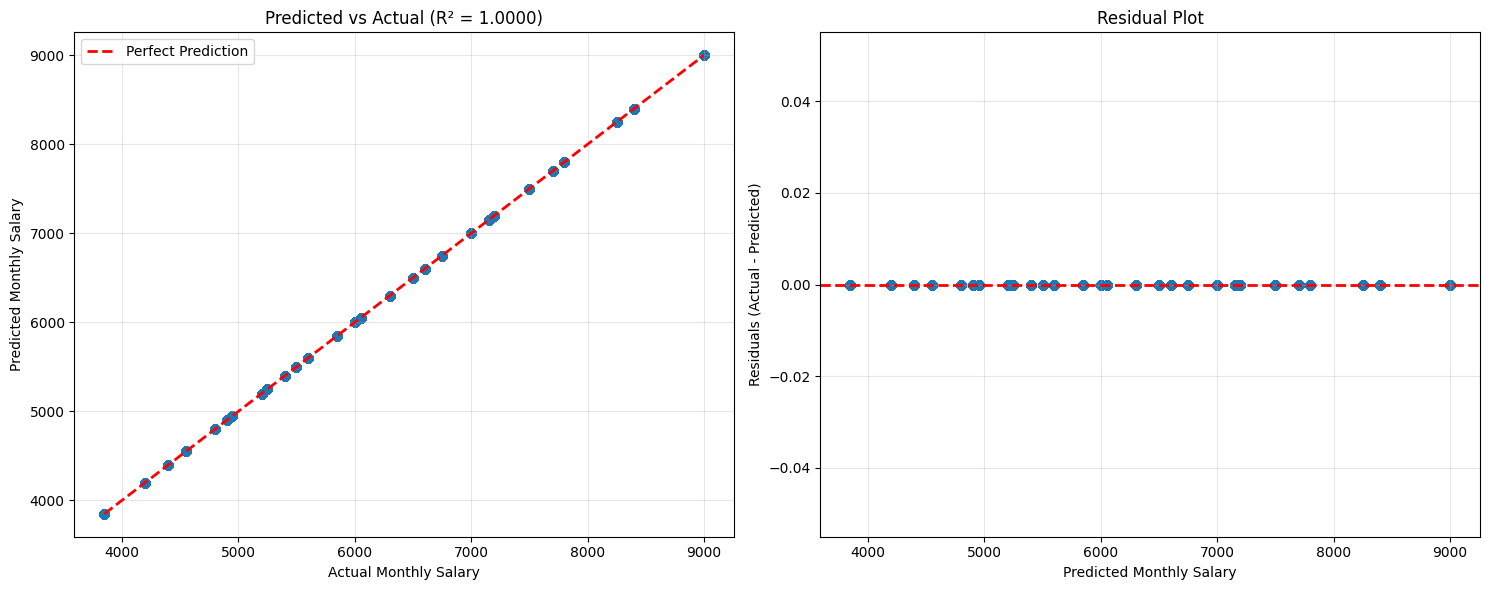

In [41]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# scatter plot: predicted vs actual
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Monthly Salary')
axes[0].set_ylabel('Predicted Monthly Salary')
axes[0].set_title(f'Predicted vs Actual (R² = {r2:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# residual plot
residuals = y_test.values.ravel() - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Monthly Salary')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Saving Model & Preprocessing Objects

In [42]:
# create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# save the best performing model
joblib.dump(best_pipeline, '../models/salary_prediction_model.pkl')

['../models/salary_prediction_model.pkl']

This notebook is done by `La Wun Nannda`.